In [1]:
from numpy import array, linspace, exp, real
from numpy.fft import *
from numpy.random import normal
from numpy.linalg import norm

def convolution(f,fourierKernel):
    g=fft(f)
    g=g*fourierKernel
    return ifftshift(ifft(g))

def fftAbelKernel(n):
    t=linspace(-1,1,n)
    t= exp(-8*abs(t))
    t=t/sum(t)
    return fft(t)

def fftGaussKernel(n):
    t=linspace(-1,1,n)
    t= exp(-16*t**2)
    t=t/sum(t)
    return fft(t)

def truth(x):
    if -1/2<x<=0:
        return 2*x+1
    elif 0<x<1/2:
        return 1-2*x
    else:
        return 0
    
    
n=100
    
t=linspace(-1,1,n)
fDagger=array([truth(x) for x in t])
noiseLevel=0.01

abelKernel=fftAbelKernel(n)
trueDataAbel=real(convolution(fDagger,abelKernel))
noise=normal(0,1,n)
dataAbel=trueDataAbel+noise/(norm(noise))*noiseLevel*norm(trueDataAbel)

gaussKernel=fftGaussKernel(n)
trueDataGauss=real(convolution(fDagger,gaussKernel))
noise=normal(0,1,n)
dataGauss=trueDataGauss+noise/(norm(noise))*noiseLevel*norm(trueDataGauss)


We now want to implement the Tikhonov approximate inverse $(\alpha I + T^*T)^{-1} T^*$. Note that with the given kernels we have $T^*=T$ (since they are realvalued and symmetric). To invert a convolution operator $A$ with kernel $kg$ note that $A=\mathcal F^* m_{\hat g} \mathcal F$ where $\mathcal F$ is the Fourier transform and $m_{\hat g}$ is the pointwise multiplication with a function $\hat g$. Hence the inverse of such an operator is given by $A^{-1}=\mathcal F^* m_{(\hat g)^{-1}} \mathcal F$. As $\alpha I + T^*T= \mathcal F^* m_{\alpha+\hat k ^2} \mathcal F$ its inverse is given by $(\alpha I + T^*T)^{-1}= \mathcal F^* m_{(\alpha+{\hat k}^2)^{-1}} \mathcal F$. Hence the full approximate inverse is given by:
$$R_\alpha= \mathcal F^* m_g \mathcal F\qquad \text{with} \qquad g(\xi)=\frac{\hat k (\xi)}{\alpha + \hat k(\xi)^2}.$$
This is the way the kernel is implemented below. Note that in principle the comvolution should be real valued, bur usually fails to do so beacause of numerical errors, hence we force it to be real valued. Further to calculated the $L^2$-norm of a function one should scale with $n^{-1/2}$ as we are considering relativ errors the scaling factor cancels.

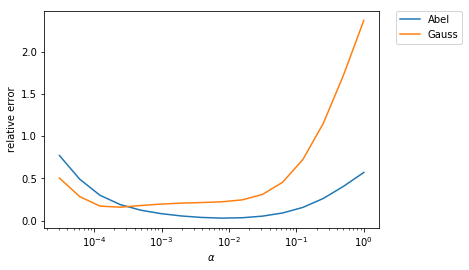

For the recnstruction with the Abel Kernel the minimal error is achieved at alpha=7.81e-03 with an relative error of 0.031
For the recnstruction with the Gauss Kernel the minimal error is achieved at alpha=2.44e-04 with an relative error of 0.160


In [2]:
from numpy import zeros
import matplotlib.pyplot as plt

Alpha=2**(-linspace(0,15,16))

errorAbel=zeros(Alpha.size)
k=0
for alpha in Alpha:
    tikhonovKernelAbel=abelKernel/(alpha+abelKernel**2)
    estimator=real(convolution(dataAbel,tikhonovKernelAbel))
    errorAbel[k]=norm(estimator-fDagger)
    k=k+1

errorAbel=errorAbel/norm(fDagger)
plt.semilogx(Alpha,errorAbel,label='Abel')


errorGauss=zeros(Alpha.size)
k=0
for alpha in Alpha:
    tikhonovKernelGauss=gaussKernel/(alpha+gaussKernel**2)
    estimator=real(convolution(dataGauss,tikhonovKernelGauss))
    errorGauss[k]=norm(estimator-fDagger)
    k=k+1

errorGauss/norm(fDagger)
plt.semilogx(Alpha,errorGauss,label='Gauss')

plt.xlabel(r'$\alpha$')
plt.ylabel('relative error')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

from numpy import argmin
print('For the recnstruction with the Abel Kernel the minimal error is achieved at alpha={:1.2e} with an relative error of {:1.3f}'.format(Alpha[argmin(errorAbel)],min(errorAbel)))
print('For the recnstruction with the Gauss Kernel the minimal error is achieved at alpha={:1.2e} with an relative error of {:1.3f}'.format(Alpha[argmin(errorGauss)],min(errorGauss)))

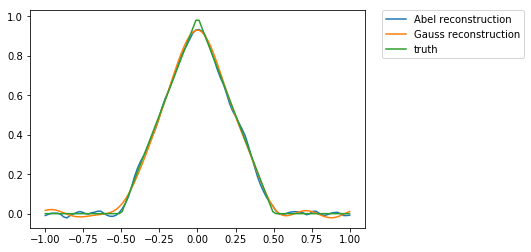

In [3]:
tikhonovKernelGauss=gaussKernel/(Alpha[argmin(errorGauss)]+gaussKernel**2)
estimatorG=real(convolution(dataGauss,tikhonovKernelGauss))

tikhonovKernelAbel=abelKernel/(Alpha[argmin(errorAbel)]+abelKernel**2)
estimatorA=real(convolution(dataAbel,tikhonovKernelAbel))

plt.plot(t,estimatorA,label='Abel reconstruction')
plt.plot(t,estimatorG,label='Gauss reconstruction')
plt.plot(t,fDagger, label='truth')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

It remains to discuss why the reconstruction from the Abel kernel is much closer to the truth then the reconstruction from the Gauss kernel, although the two kernel are very similar. For this we note that
$$\hat k_1(\xi) \sim \frac{1}{1+\xi^2} \qquad \hat k_2(\xi) \sim \exp(-|\xi|^2)$$
i.e. $\hat k_2$ decaysexponentially to zero wheras $\hat k_1$ only decays polynomially. Due to the decay at infinity of the Fourier transform of the kernel, the problem with the Abel Kernel is only mildly ill-posed whereas the problem with the Gauss kernel is exponentially ill-posed, hence the reconstruction from the Abel kernel is better, as the noise gets less amplified during the reconstruction.